<a href="https://colab.research.google.com/github/NitinKumar4338/Topic-Modeling-on-News-Articles/blob/main/News_Topic_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Project Title : Extraction/identification of major topics & themes discussed in news articles.

### Problem Description
### In this project your task is to identify major themes/topics across a collection of BBC news articles. You can use clustering algorithms such as Latent Dirichlet Allocation (LDA), Latent Semantic Analysis (LSA) etc.

### Data Description
### The dataset contains a set of news articles for each major segment consisting of business, entertainment, politics, sports and technology. You need to create an aggregate dataset of all the news articles and perform topic modeling on this dataset. Verify whether these topics correspond to the different tags available.

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.metrics import accuracy_score, classification_report
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('bbc.csv')

### First Look of Data

In [3]:
data.head()

Unnamed: 0                                               news      type
0           0  Ad sales boost Time Warner profit\n \n Quarter...  business
1           1  Dollar gains on Greenspan speech\n \n The doll...  business
2           2  Yukos unit buyer faces loan claim\n \n The own...  business
3           3  High fuel prices hit BA's profits\n \n British...  business
4           4  Pernod takeover talk lifts Domecq\n \n Shares ...  business

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  2225 non-null   int64 
 1   news        2225 non-null   object
 2   type        2225 non-null   object
dtypes: int64(1), object(2)
memory usage: 52.3+ KB


In [5]:
data.shape

(2225, 3)

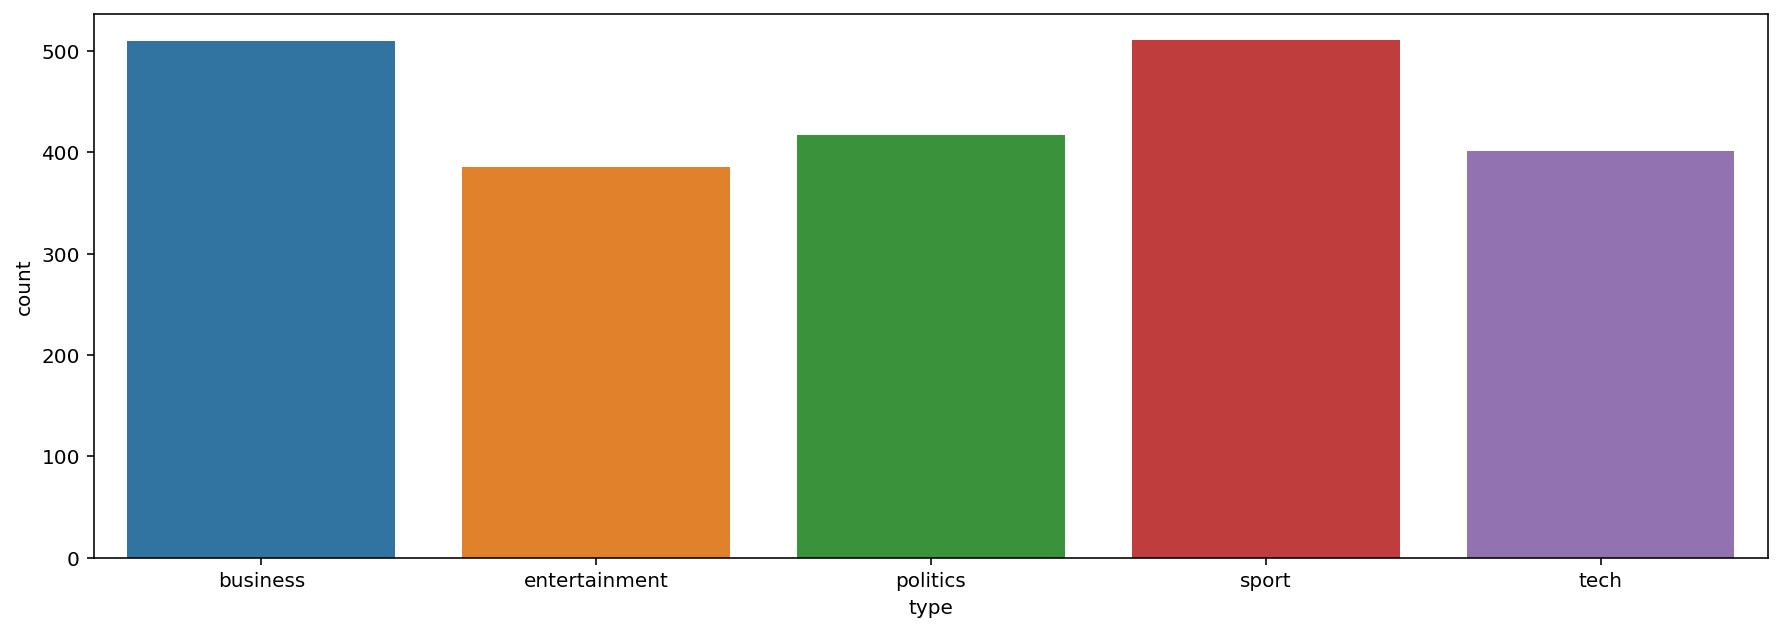

In [6]:
plt.figure(figsize=(15, 5))
sns.countplot(data.type)

In [7]:
data['News_length'] = data['news'].str.len()
print(data['News_length'])

0        2570
1        2258
2        1558
3        2422
4        1576
        ...  
2220     2527
2221     2295
2222     6298
2223     2324
2224    16249
Name: News_length, Length: 2225, dtype: int64


In [8]:
data.head()

Unnamed: 0                                               news      type  \
0           0  Ad sales boost Time Warner profit\n \n Quarter...  business   
1           1  Dollar gains on Greenspan speech\n \n The doll...  business   
2           2  Yukos unit buyer faces loan claim\n \n The own...  business   
3           3  High fuel prices hit BA's profits\n \n British...  business   
4           4  Pernod takeover talk lifts Domecq\n \n Shares ...  business   

   News_length  
0         2570  
1         2258  
2         1558  
3         2422  
4         1576

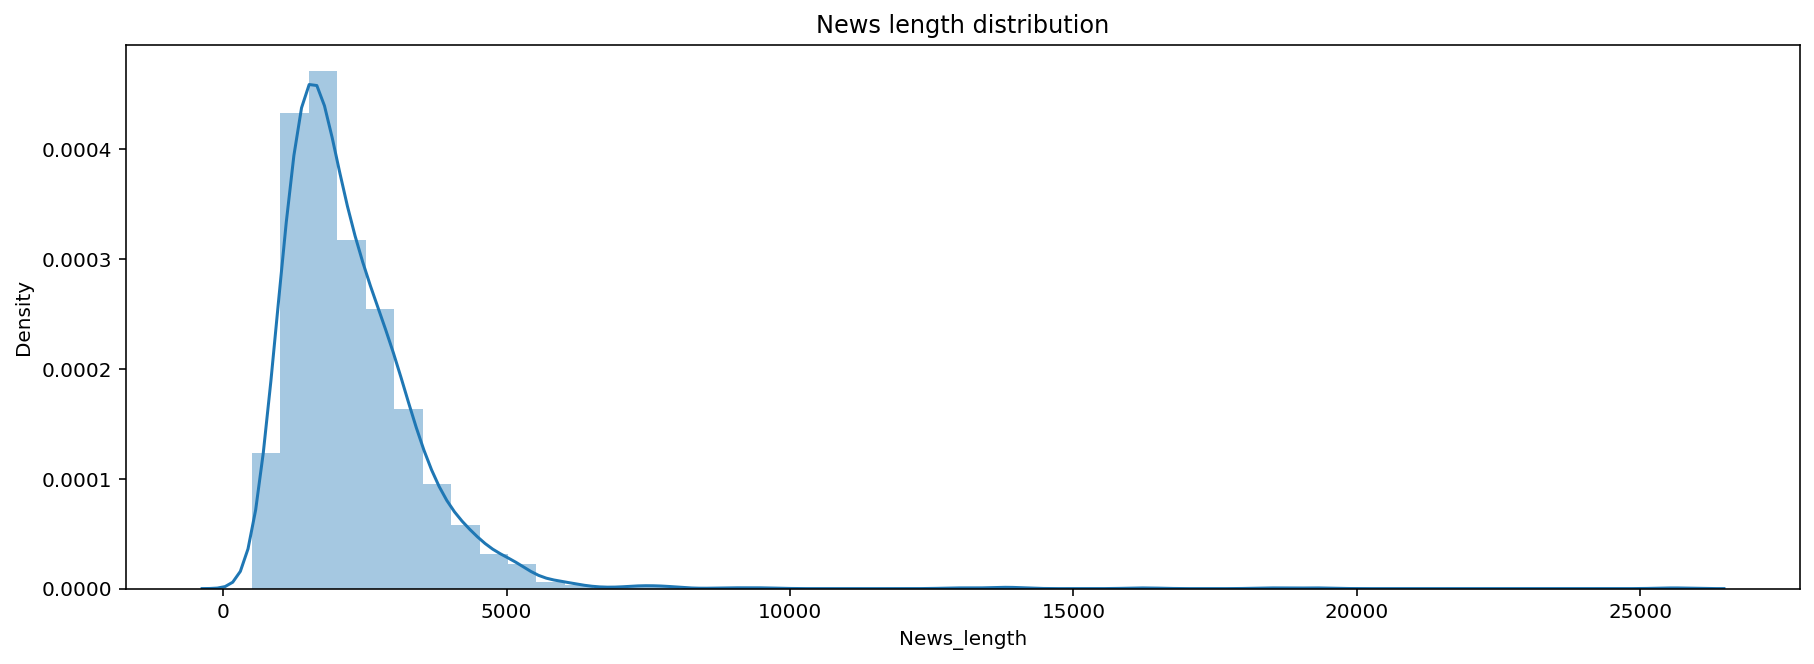

In [9]:
plt.figure(figsize=(15, 5))
sns.distplot(data['News_length']).set_title('News length distribution');

### Funtion to remove punctuation

In [10]:
def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [11]:
data['news'] = data['news'].apply(remove_punctuation)
data.head(10)

Unnamed: 0                                               news      type  \
0           0  Ad sales boost Time Warner profit\n \n Quarter...  business   
1           1  Dollar gains on Greenspan speech\n \n The doll...  business   
2           2  Yukos unit buyer faces loan claim\n \n The own...  business   
3           3  High fuel prices hit BAs profits\n \n British ...  business   
4           4  Pernod takeover talk lifts Domecq\n \n Shares ...  business   
5           5  Japan narrowly escapes recession\n \n Japans e...  business   
6           6  Jobs growth still slow in the US\n \n The US c...  business   
7           7  India calls for fair trade rules\n \n India wh...  business   
8           8  Ethiopias crop production up 24\n \n Ethiopia ...  business   
9           9  Court rejects 280bn tobacco case\n \n A US gov...  business   

   News_length  
0         2570  
1         2258  
2         1558  
3         2422  
4         1576  
5         1193  
6         1677  
7         1928  
8         1502  
9         1455

### Removeing Stop Words From Data

In [12]:
import nltk
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words("english")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
sw = stopwords[:]

In [14]:
print("Number of stopwords: ", len(sw))

Number of stopwords:  179


In [15]:
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [16]:
data['news'] = data['news'].apply(stopwords)
data.head(10)

Unnamed: 0                                               news      type  \
0           0  ad sales boost time warner profit quarterly pr...  business   
1           1  dollar gains greenspan speech dollar hit highe...  business   
2           2  yukos unit buyer faces loan claim owners embat...  business   
3           3  high fuel prices hit bas profits british airwa...  business   
4           4  pernod takeover talk lifts domecq shares uk dr...  business   
5           5  japan narrowly escapes recession japans econom...  business   
6           6  jobs growth still slow us us created fewer job...  business   
7           7  india calls fair trade rules india attends g7 ...  business   
8           8  ethiopias crop production 24 ethiopia produced...  business   
9           9  court rejects 280bn tobacco case us government...  business   

   News_length  
0         2570  
1         2258  
2         1558  
3         2422  
4         1576  
5         1193  
6         1677  
7         1928  
8         1502  
9         1455

### Collect vocabulary count

In [17]:
# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(data['news'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()

In [18]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

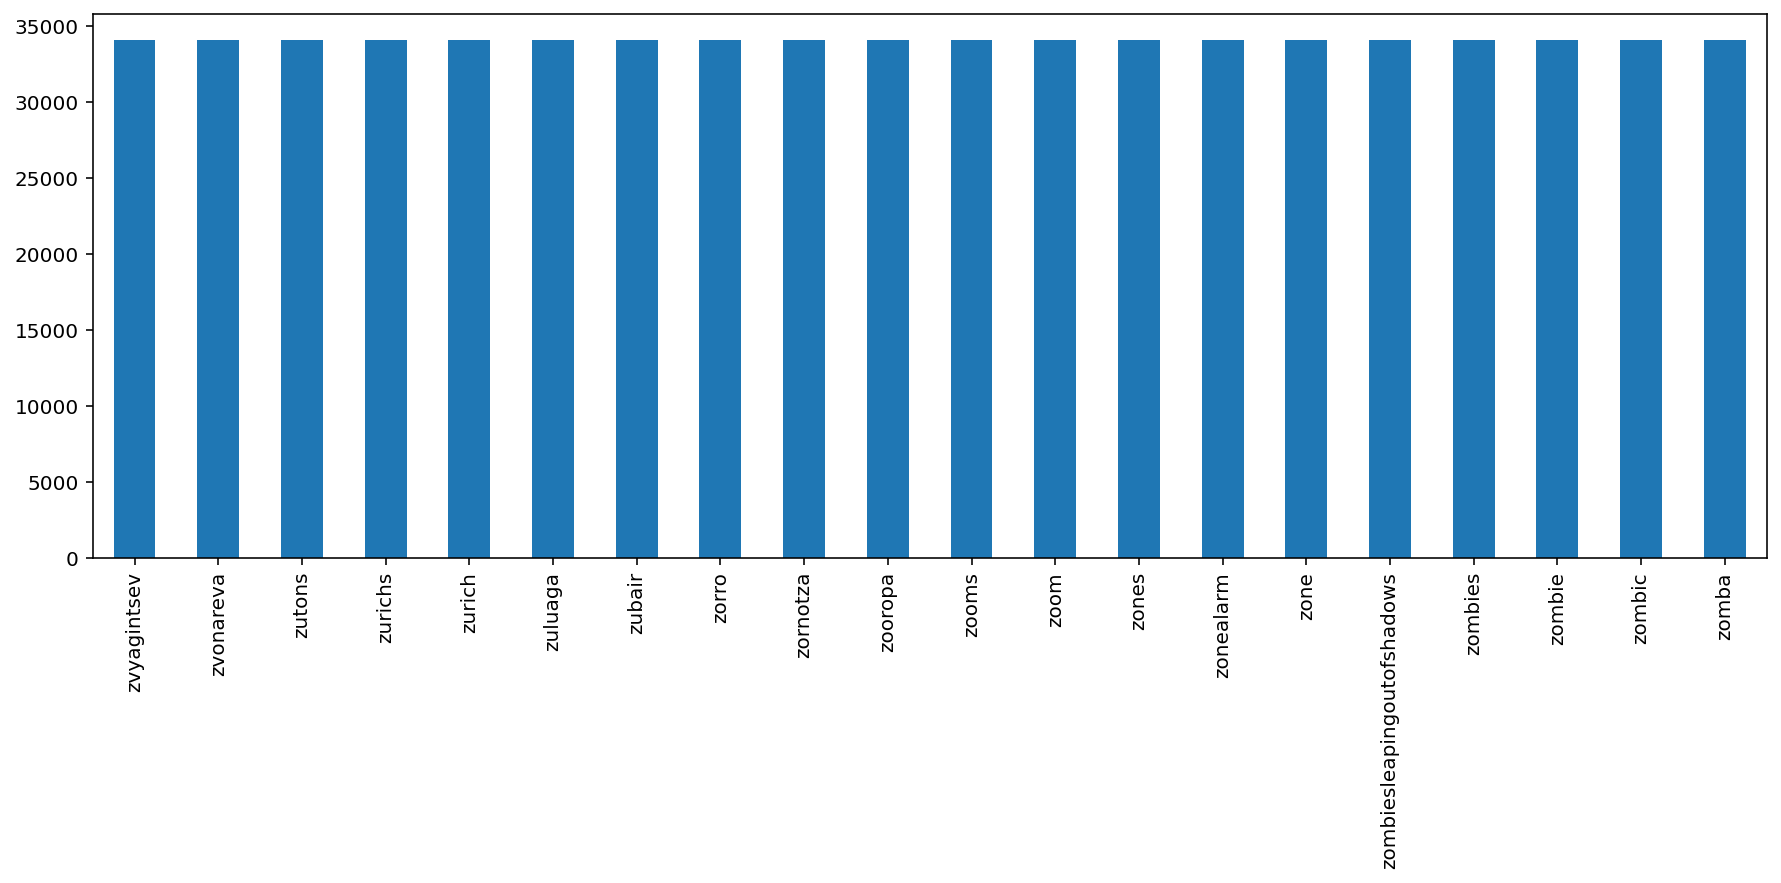

In [19]:
top_vacab = vocab_bef_stem.head(20)
top_vacab.plot(kind = 'bar', figsize=(15,5))

### Stemming 

In [20]:
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [21]:
data['news'] = data['news'].apply(stemming)
data.head(10)

Unnamed: 0                                               news      type  \
0           0  ad sale boost time warner profit quarter profi...  business   
1           1  dollar gain greenspan speech dollar hit highes...  business   
2           2  yuko unit buyer face loan claim owner embattl ...  business   
3           3  high fuel price hit bas profit british airway ...  business   
4           4  pernod takeov talk lift domecq share uk drink ...  business   
5           5  japan narrowli escap recess japan economi teet...  business   
6           6  job growth still slow us us creat fewer job ex...  business   
7           7  india call fair trade rule india attend g7 mee...  business   
8           8  ethiopia crop product 24 ethiopia produc 1427 ...  business   
9           9  court reject 280bn tobacco case us govern clai...  business   

   News_length  
0         2570  
1         2258  
2         1558  
3         2422  
4         1576  
5         1193  
6         1677  
7         1928  
8         1502  
9         1455

In [22]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer(stop_words = 'english')

# fit the vectorizer using the text data
tfid_vectorizer.fit(data['news'])

# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

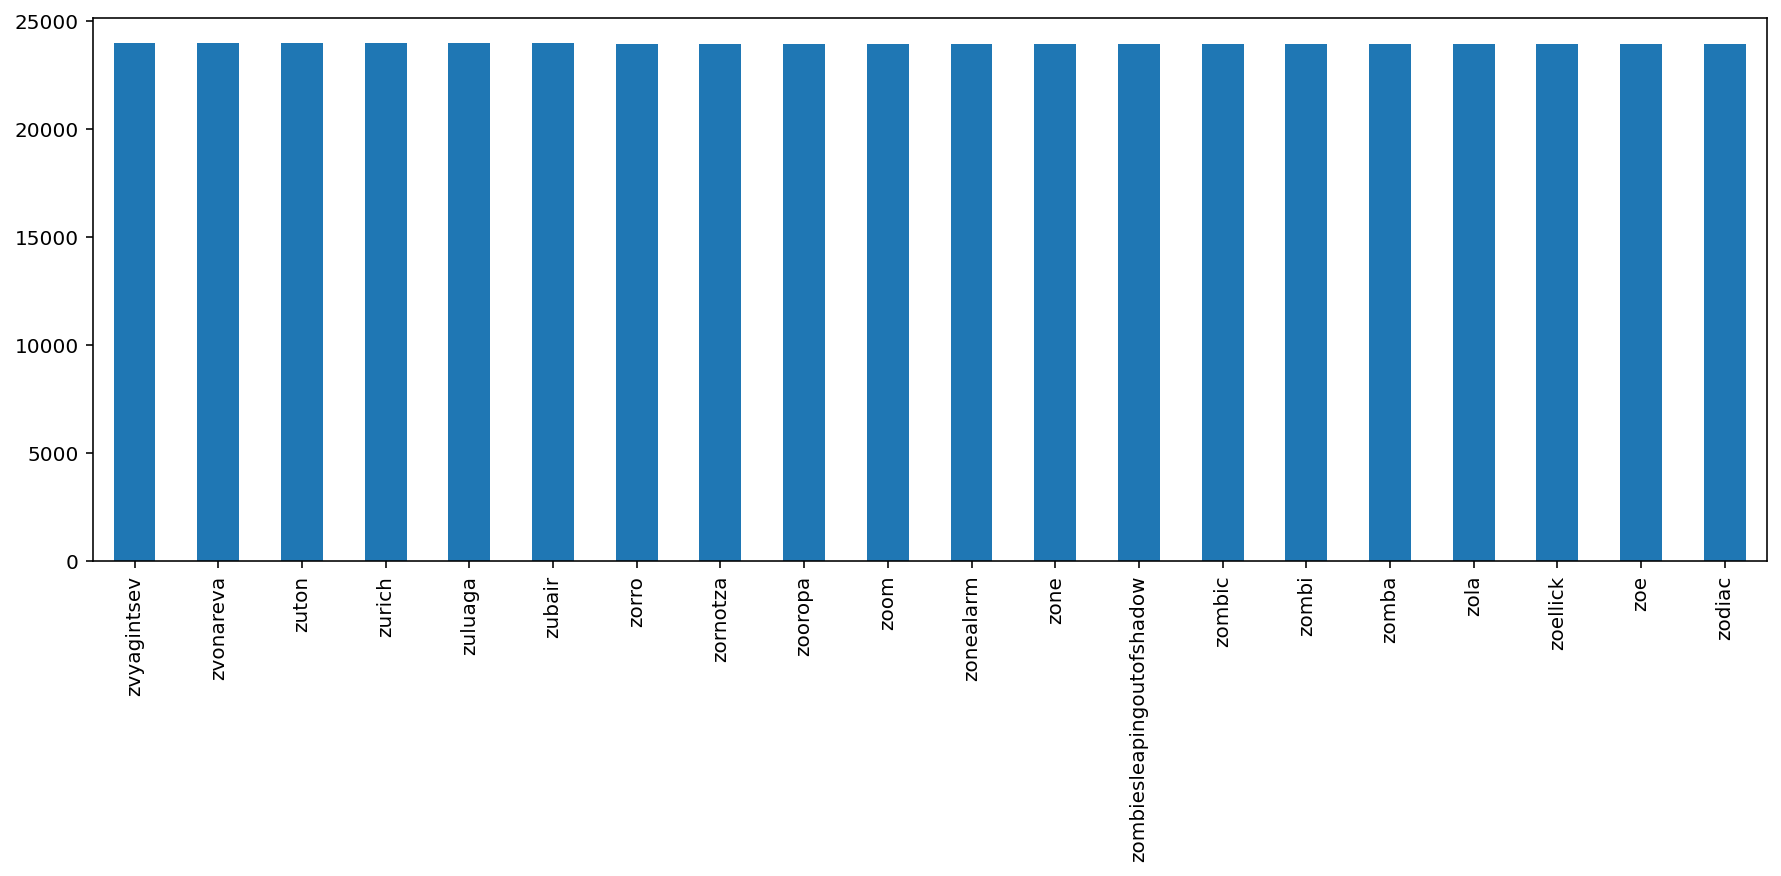

In [23]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'bar', figsize=(15,5))

In [24]:
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

In [25]:
data['length'] = data['news'].apply(length)
data.head(10)

Unnamed: 0                                               news      type  \
0           0  ad sale boost time warner profit quarter profi...  business   
1           1  dollar gain greenspan speech dollar hit highes...  business   
2           2  yuko unit buyer face loan claim owner embattl ...  business   
3           3  high fuel price hit bas profit british airway ...  business   
4           4  pernod takeov talk lift domecq share uk drink ...  business   
5           5  japan narrowli escap recess japan economi teet...  business   
6           6  job growth still slow us us creat fewer job ex...  business   
7           7  india call fair trade rule india attend g7 mee...  business   
8           8  ethiopia crop product 24 ethiopia produc 1427 ...  business   
9           9  court reject 280bn tobacco case us govern clai...  business   

   News_length  length  
0         2570    1627  
1         2258    1458  
2         1558    1006  
3         2422    1631  
4         1576    1041  
5         1193     751  
6         1677    1054  
7         1928    1206  
8         1502    1002  
9         1455     940

In [26]:
Business_data = data[data['type'] == 'business']
Entertainment_data = data[data['type'] == 'entertainment']
Politics_data = data[data['type'] == 'politics']
Sport_data = data[data['type'] == 'sport']
Tech_data = data[data['type'] == 'tech']

In [27]:
Business_data

Unnamed: 0                                               news      type  \
0             0  ad sale boost time warner profit quarter profi...  business   
1             1  dollar gain greenspan speech dollar hit highes...  business   
2             2  yuko unit buyer face loan claim owner embattl ...  business   
3             3  high fuel price hit bas profit british airway ...  business   
4             4  pernod takeov talk lift domecq share uk drink ...  business   
..          ...                                                ...       ...   
505         505  trial begin spain top banker trial emilio boti...  business   
506         506  uk economi end year spurt uk economi grew esti...  business   
507         507  healthsouth exboss goe trial former head us me...  business   
508         508  euro firm miss optim 90 larg compani around wo...  business   
509         509  lacroix label bought us firm luxuri good group...  business   

     News_length  length  
0           2570    1627  
1           2258    1458  
2           1558    1006  
3           2422    1631  
4           1576    1041  
..           ...     ...  
505         1632    1060  
506         2850    1780  
507         1408     906  
508         2631    1589  
509          894     598  

[510 rows x 5 columns]

### Count of words in Business data

In [28]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer(stop_words = 'english')

# fit the vectorizer using the text data
tfid_vectorizer.fit(Business_data['news'])

# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

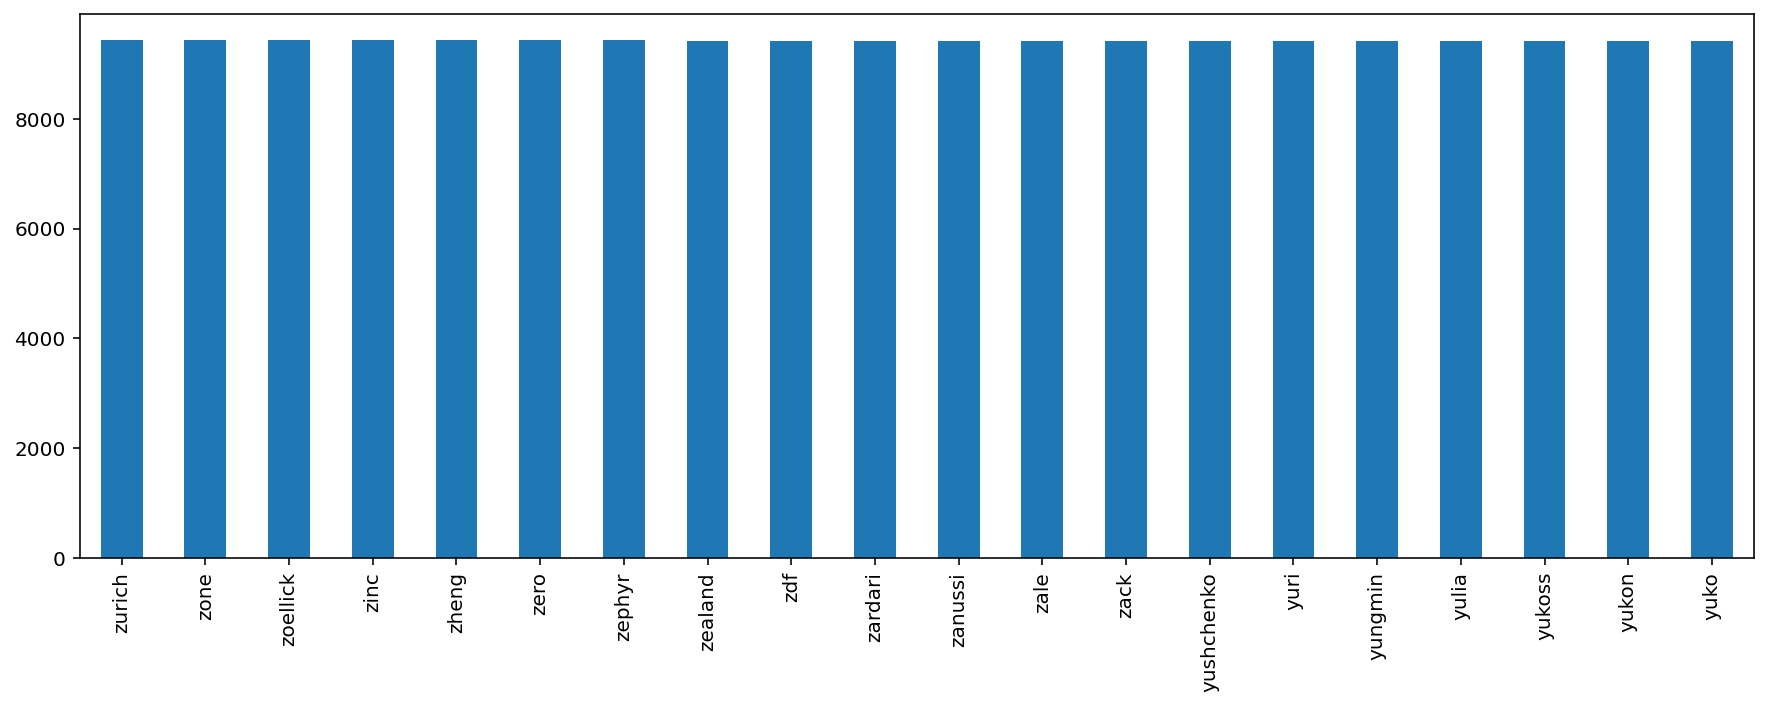

In [29]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'bar', figsize=(15,5))

### Count of words in Entertainment data

In [30]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer(stop_words = 'english')

# fit the vectorizer using the text data
tfid_vectorizer.fit(Entertainment_data['news'])

# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

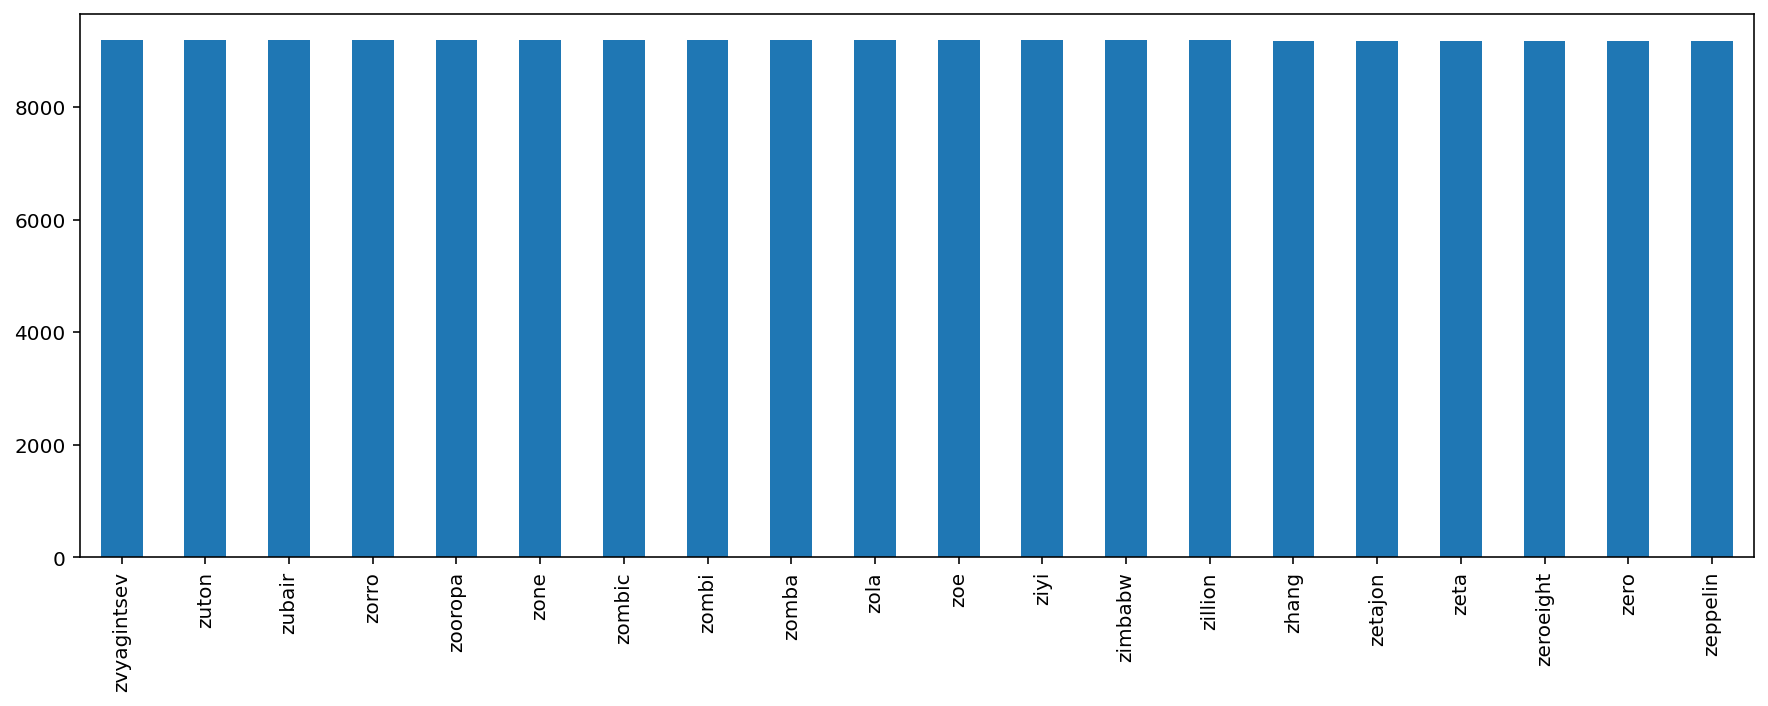

In [31]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'bar', figsize=(15,5))

### Count of words in Politics data

In [32]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer(stop_words = 'english')

# fit the vectorizer using the text data
tfid_vectorizer.fit(Politics_data['news'])

# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

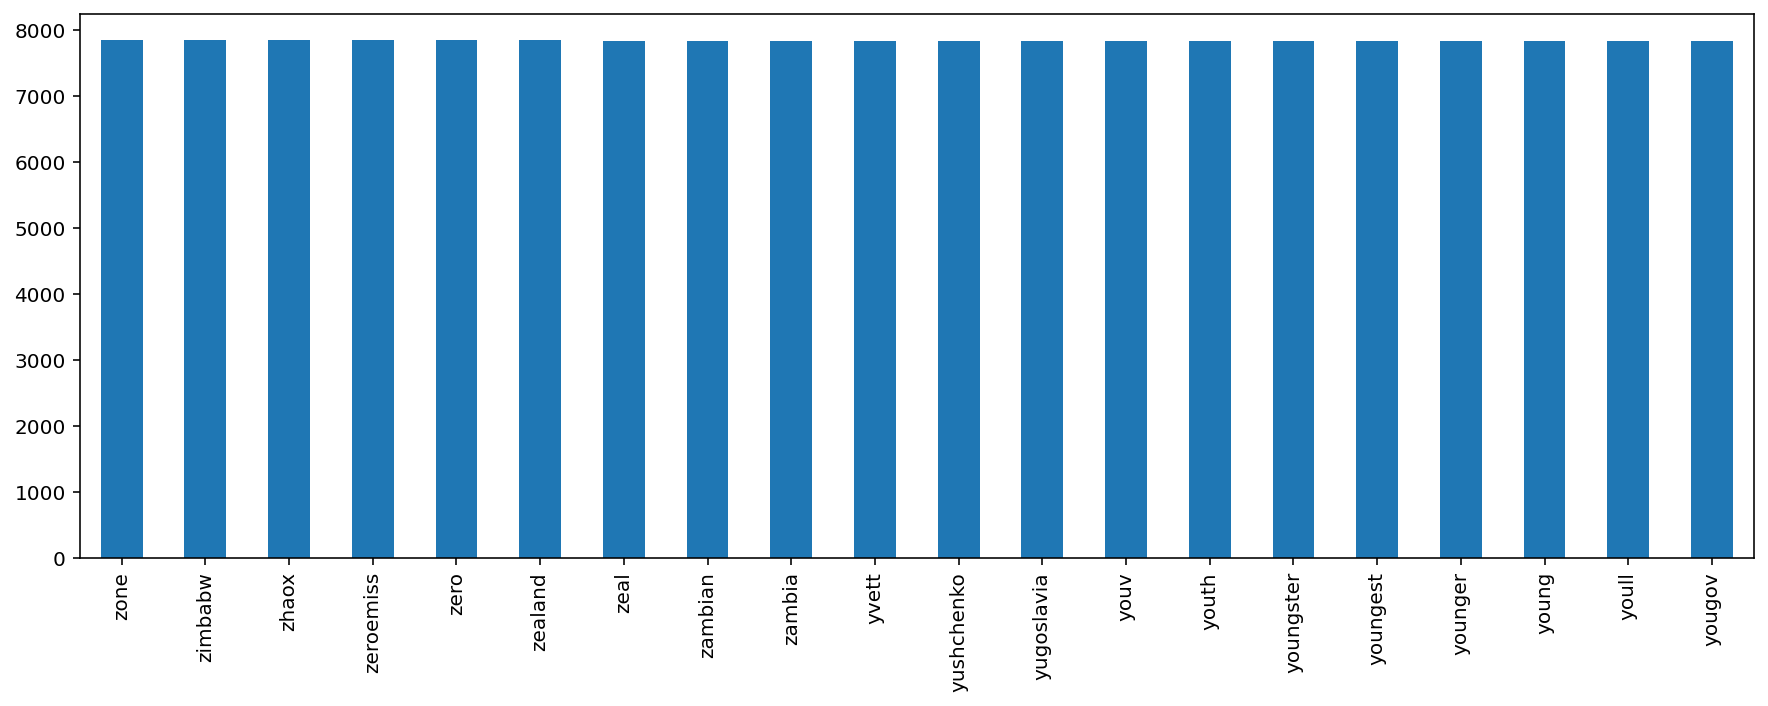

In [33]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'bar', figsize=(15,5))

### Count of words in Sport data

In [34]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer(stop_words = 'english')

# fit the vectorizer using the text data
tfid_vectorizer.fit(Sport_data['news'])

# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

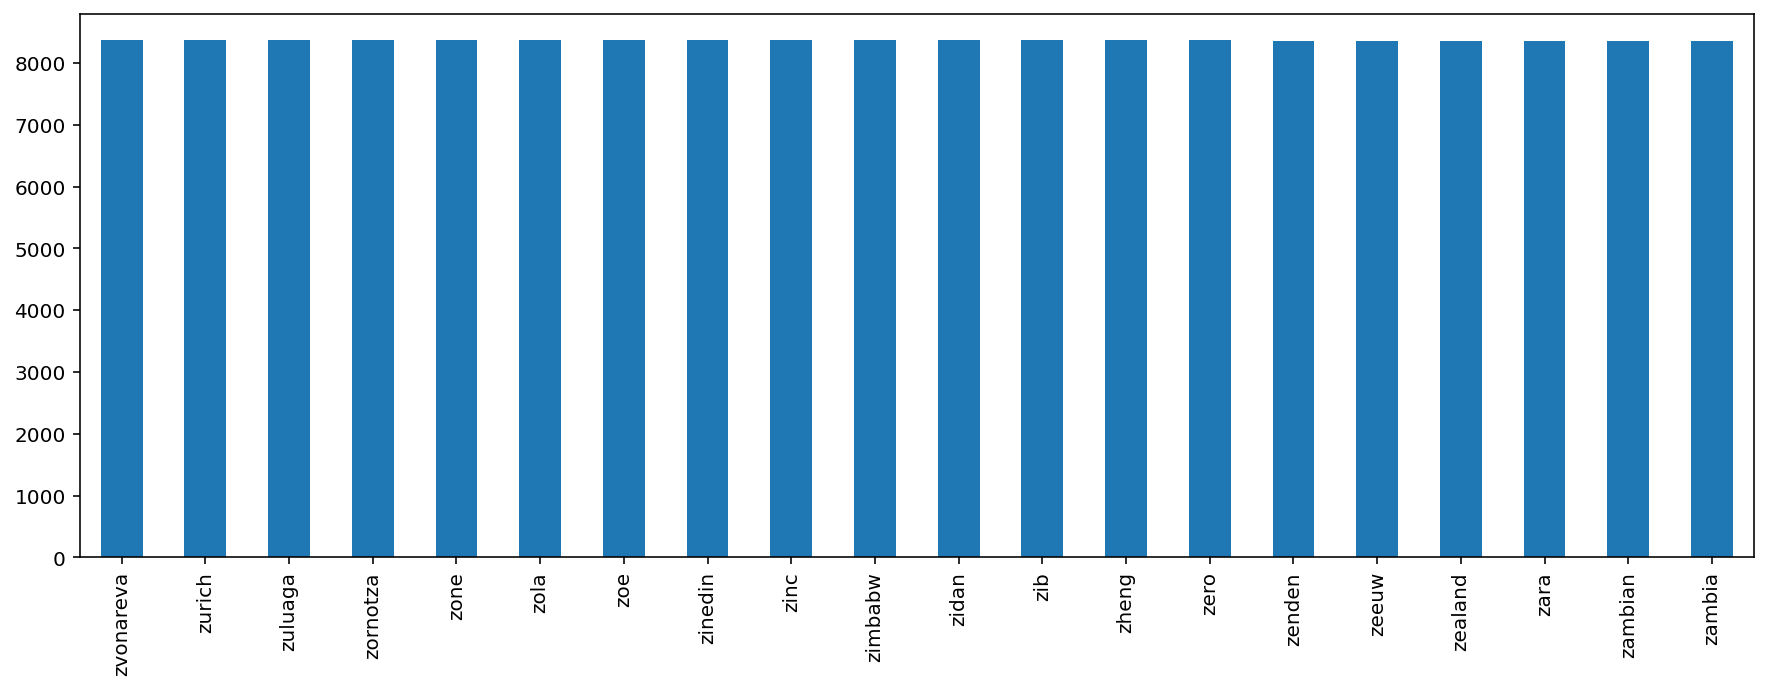

In [35]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'bar', figsize=(15,5))

### Count of words in Tech data

In [36]:
# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer(stop_words = 'english')

# fit the vectorizer using the text data
tfid_vectorizer.fit(Tech_data['news'])

# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()

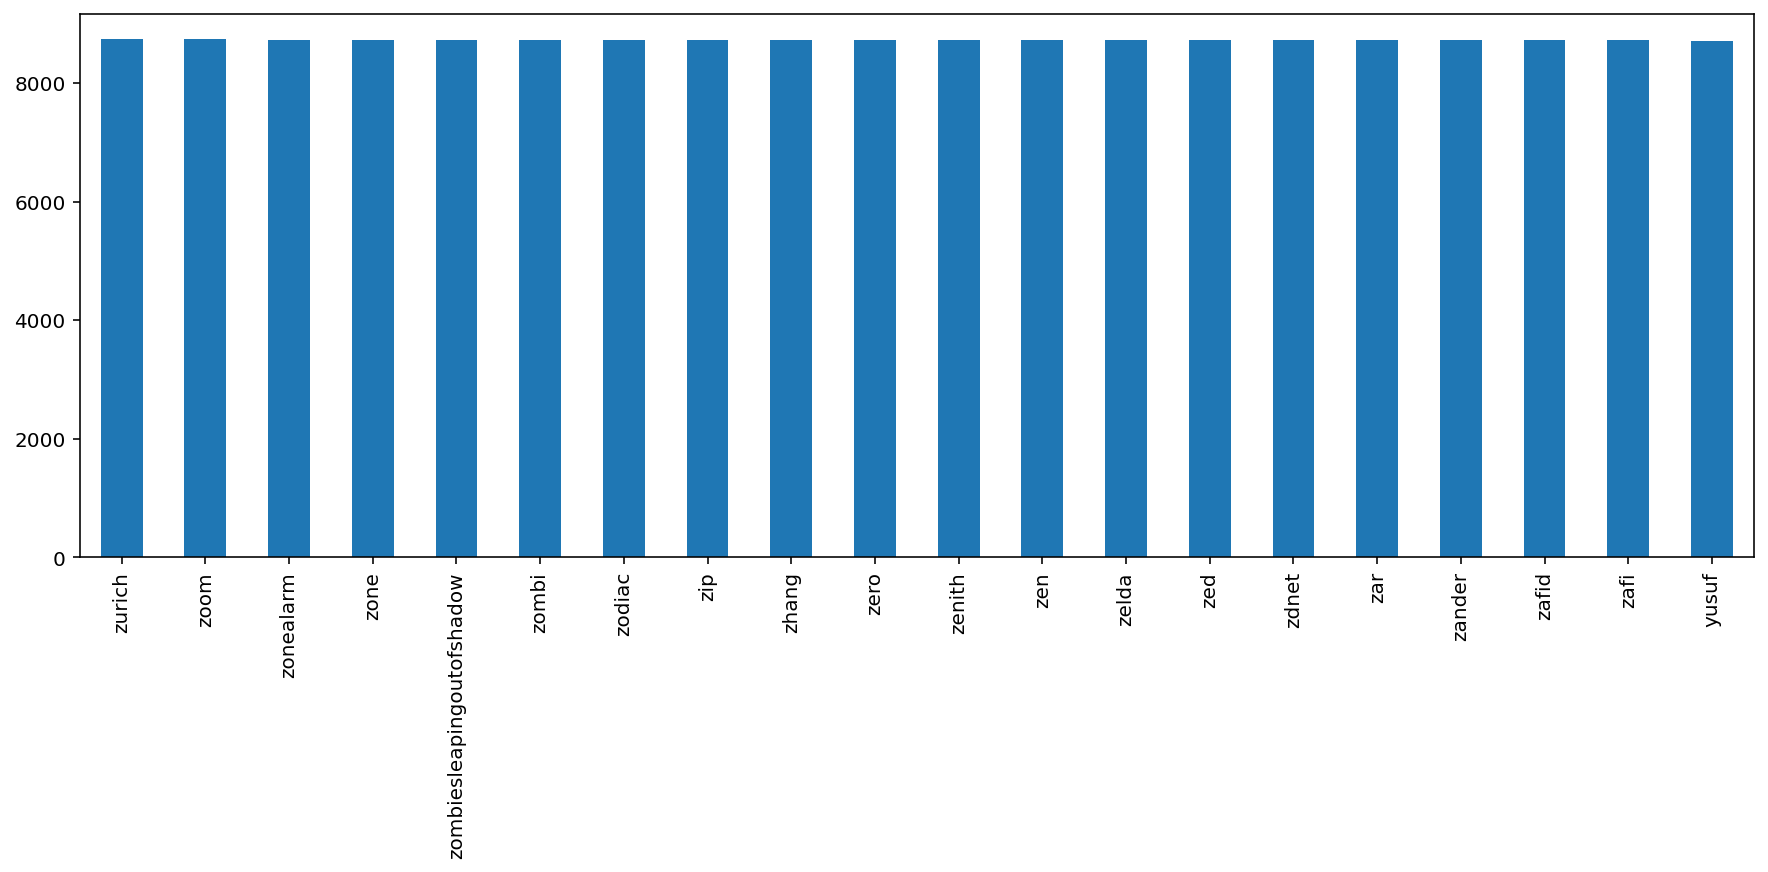

In [37]:
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'bar', figsize=(15,5))

### Word Cloud

In [38]:
from wordcloud import WordCloud ,STOPWORDS

In [39]:
def create_wordcloud(words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

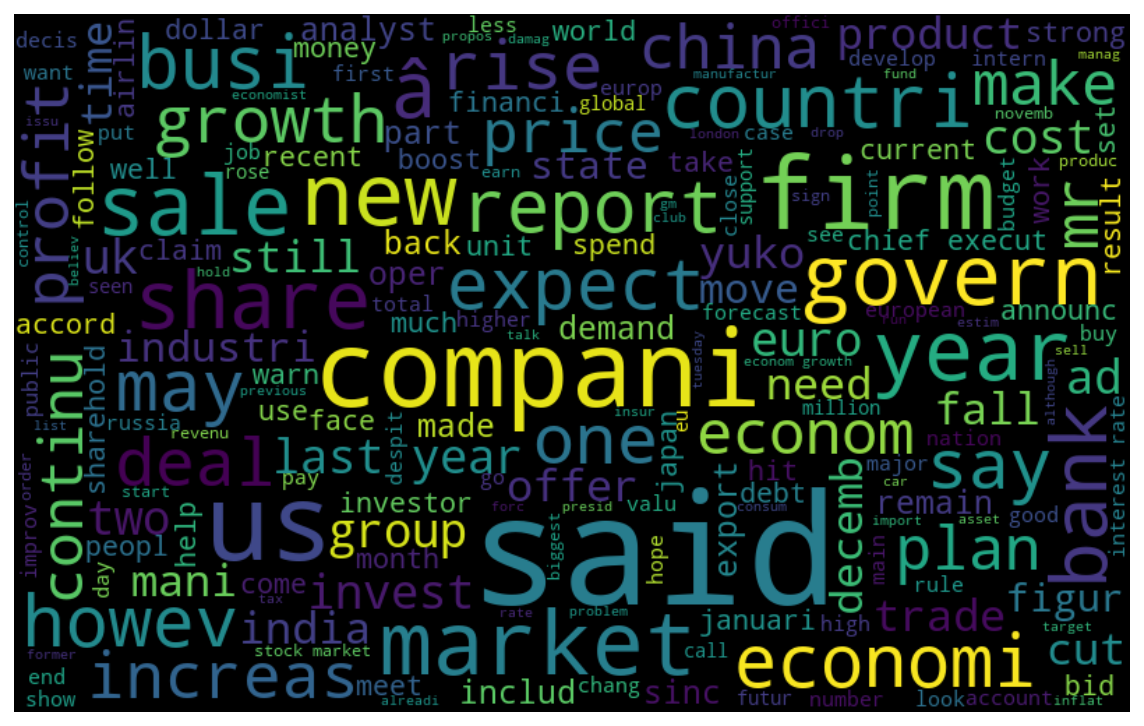

In [40]:
subset=data[data.type=="business"]
text=subset.news.values
words =" ".join(text)
create_wordcloud(words)

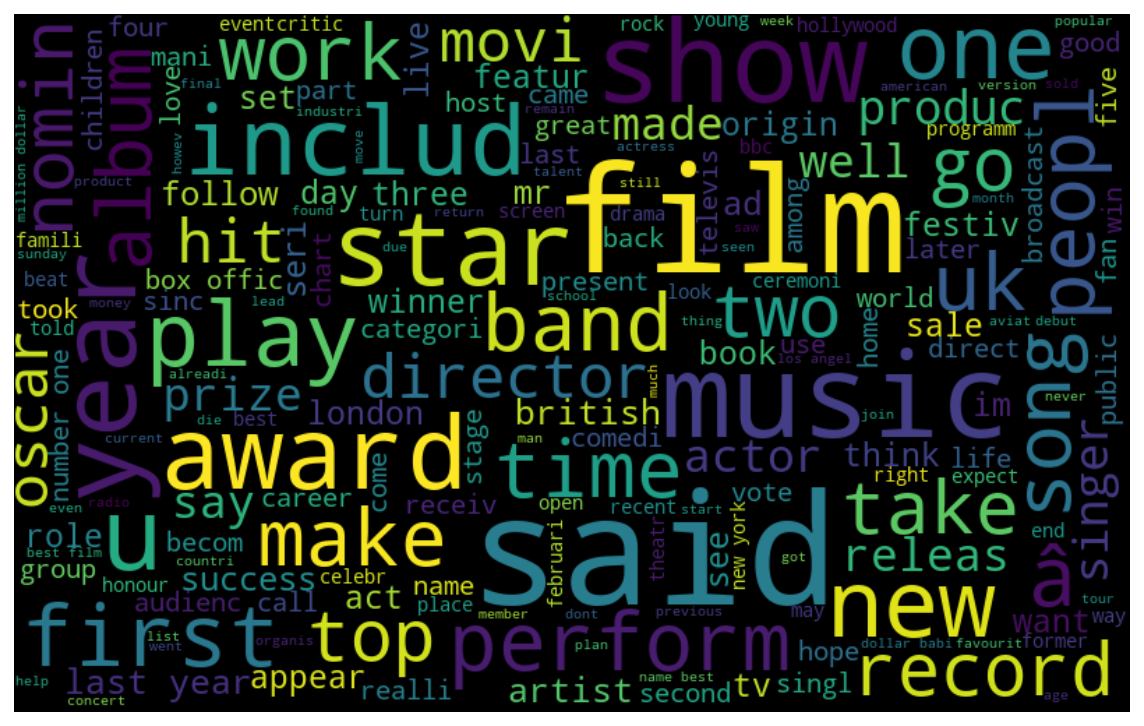

In [41]:
subset=data[data.type=="entertainment"]
text=subset.news.values
words =" ".join(text)
create_wordcloud(words)

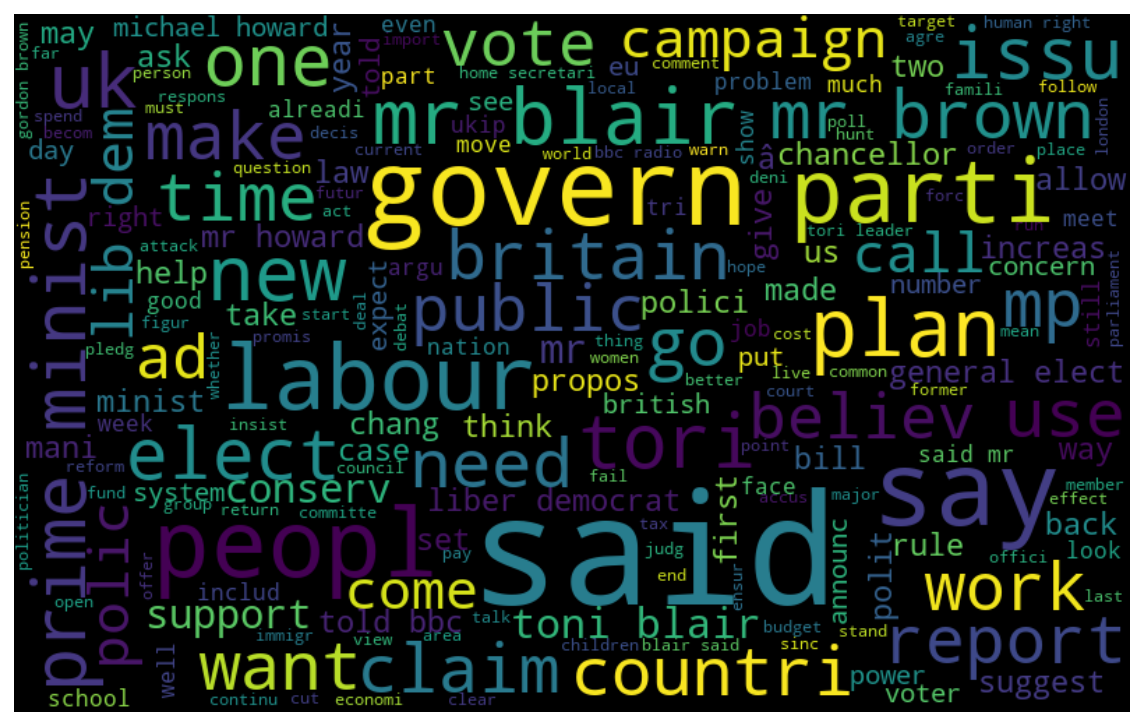

In [42]:
subset=data[data.type=="politics"]
text=subset.news.values
words =" ".join(text)
create_wordcloud(words)

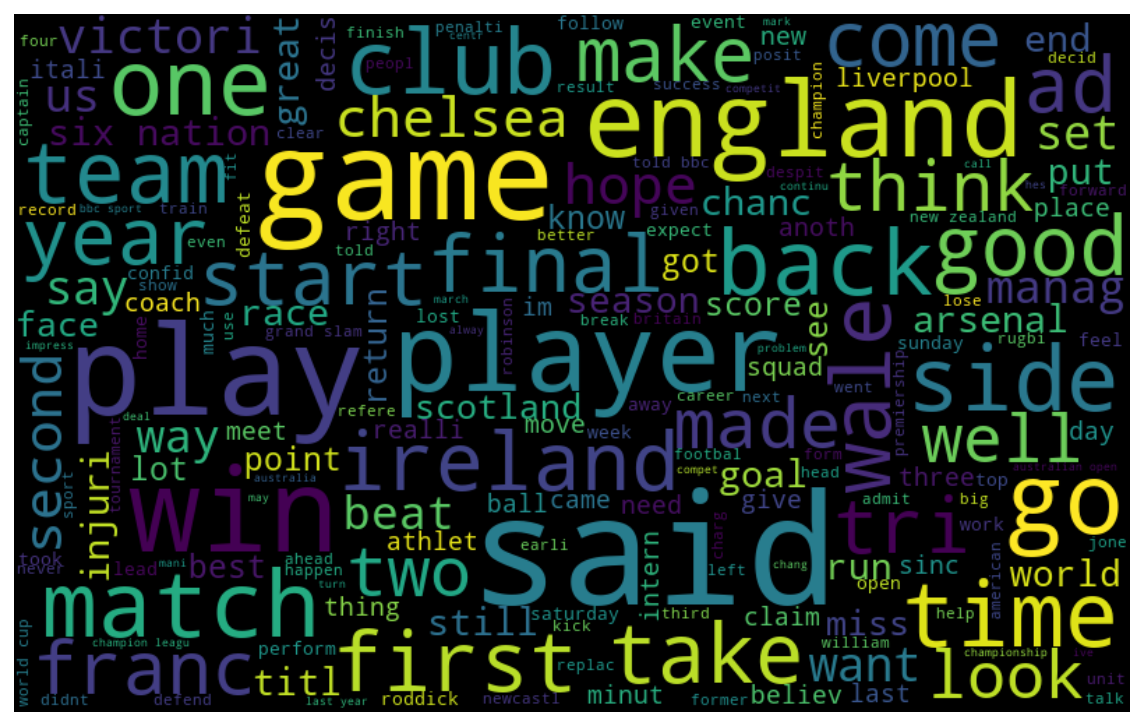

In [43]:
subset=data[data.type=="sport"]
text=subset.news.values
words =" ".join(text)
create_wordcloud(words)

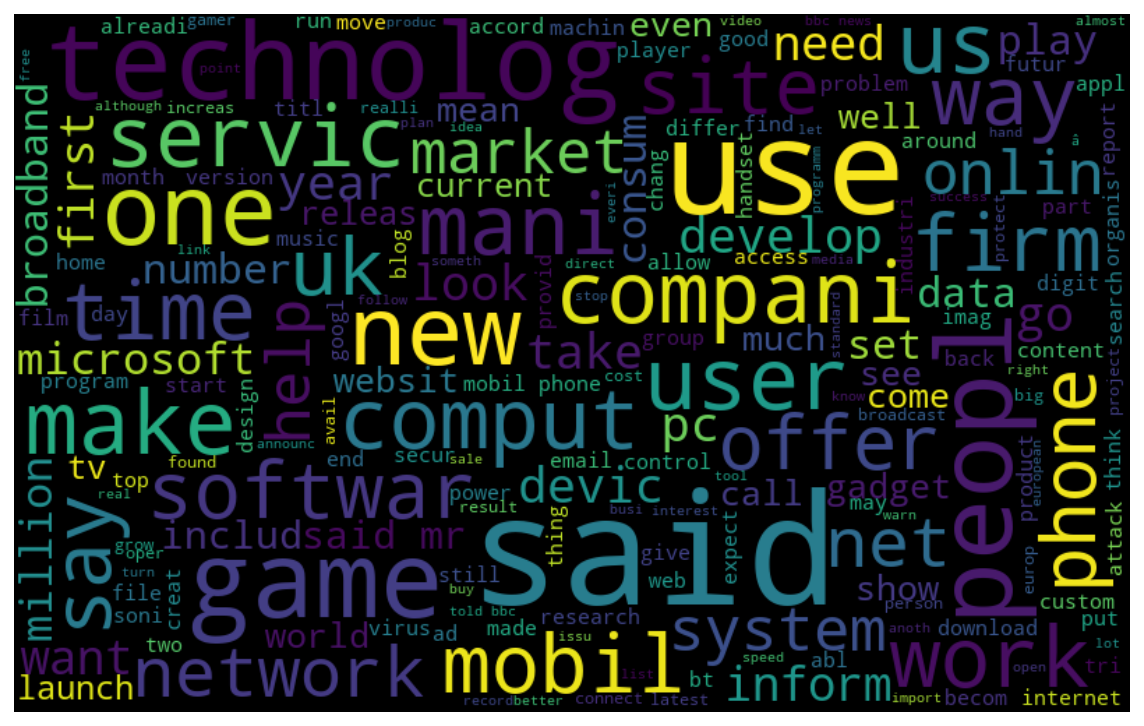

In [44]:
subset=data[data.type=="tech"]
text=subset.news.values
words =" ".join(text)
create_wordcloud(words)

### Topic Modeling

In [45]:
df = data.copy()

In [46]:
df.head()

Unnamed: 0                                               news      type  \
0           0  ad sale boost time warner profit quarter profi...  business   
1           1  dollar gain greenspan speech dollar hit highes...  business   
2           2  yuko unit buyer face loan claim owner embattl ...  business   
3           3  high fuel price hit bas profit british airway ...  business   
4           4  pernod takeov talk lift domecq share uk drink ...  business   

   News_length  length  
0         2570    1627  
1         2258    1458  
2         1558    1006  
3         2422    1631  
4         1576    1041

In [47]:
df2 = df[['news']]

In [48]:
df2.head()

news
0  ad sale boost time warner profit quarter profi...
1  dollar gain greenspan speech dollar hit highes...
2  yuko unit buyer face loan claim owner embattl ...
3  high fuel price hit bas profit british airway ...
4  pernod takeov talk lift domecq share uk drink ...

In [49]:
vectorizer = TfidfVectorizer(max_df=0.8, max_features=8000,min_df=0.05)

In [50]:
matrix=vectorizer.fit_transform(df2['news'])

In [51]:
df1 = pd.DataFrame(matrix.todense() , columns=vectorizer.get_feature_names())

In [52]:
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(5,10))}
model=LatentDirichletAllocation()
lda_model = GridSearchCV(model,param_grid=grid_params)
lda_model.fit(matrix)
best_lda_model = lda_model.best_estimator_
print("Best LDA model's params" , lda_model.best_params_)

Best LDA model's params {'n_components': 5}


In [53]:
lda_topic_matrix= best_lda_model.transform(matrix)

In [54]:
doc = pd.DataFrame(best_lda_model.transform(matrix))

In [55]:
doc.columns=['topic1','topic2','topic3','topic4','topic5']

In [56]:
from collections import Counter
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [57]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [58]:
from sklearn.manifold import TSNE
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 2225 samples in 0.002s...
[t-SNE] Computed neighbors for 2225 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2225
[t-SNE] Computed conditional probabilities for sample 2000 / 2225
[t-SNE] Computed conditional probabilities for sample 2225 / 2225
[t-SNE] Mean sigma: 0.002214
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.077591
[t-SNE] KL divergence after 2000 iterations: 0.226801


In [63]:
! pip install sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=cc4d8aa40a52ccdb1d5cd8a0ee8628c1698ee87d6af346a22cf4d7de51da1b43
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [65]:
! pip install pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=8057a7243e24e1f63ae20e13a357ff02061ccc06fd89d40d0a504134f3f14966
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [66]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable
/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping


In [67]:
lda_panel = pyLDAvis.sklearn.prepare(best_lda_model,matrix,vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
2      150.222153  -72.269554       1        1  38.494661
1       51.163364 -159.968018       2        1  23.801052
0      -73.144554   21.523815       3        1  22.150483
4      -66.410133 -110.606438       4        1  13.025245
3       54.417324   12.443444       5        1   2.528559, topic_info=        Term        Freq       Total Category  logprob  loglift
251     film   73.000000   73.000000  Default  30.0000  30.0000
65     award   45.000000   45.000000  Default  29.0000  29.0000
600     star   40.000000   40.000000  Default  28.0000  28.0000
422       mr  101.000000  101.000000  Default  27.0000  27.0000
424    music   46.000000   46.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
494  product    0.550071   29.461374   Topic5  -6.5574  -0.3033
500  protect    0.550064   17.062486   Topic5  -6.5574   0.2429
262  footbal    0.550062   17.104863   Topic5  -6.5574   0.2404
172    debut    0.550040   13.107257   Topic5  -6.5574   0.5066
610   street    0.550032   13.864352   Topic5  -6.5574   0.4504

[266 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
10        1  0.714725  2004
10        2  0.028589  2004
10        3  0.085767  2004
10        4  0.142945  2004
10        5  0.028589  2004
...     ...       ...   ...
701       1  0.456665  year
701       2  0.140512  year
701       3  0.187350  year
701       4  0.210769  year
701       5  0.011709  year

[867 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 5, 4])

### Lable Encoding

In [68]:
from sklearn import preprocessing 
label_encoder = preprocessing.LabelEncoder() 
data['type']= label_encoder.fit_transform(data['type']) 

In [69]:
data.head()

Unnamed: 0                                               news  type  \
0           0  ad sale boost time warner profit quarter profi...     0   
1           1  dollar gain greenspan speech dollar hit highes...     0   
2           2  yuko unit buyer face loan claim owner embattl ...     0   
3           3  high fuel price hit bas profit british airway ...     0   
4           4  pernod takeov talk lift domecq share uk drink ...     0   

   News_length  length  
0         2570    1627  
1         2258    1458  
2         1558    1006  
3         2422    1631  
4         1576    1041

### Train Test Split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(data['news'], 
                                                    data['type'], 
                                                    test_size=0.2, 
                                                    random_state=8)

In [71]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [72]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

[[0.         0.         0.         ... 0.         0.10225143 0.15906451]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.07273989 0.09250874 0.        ]
 ...
 [0.12025579 0.12350399 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.06805008 0.06252272]]
(445, 300)


### Implementation of Various models

### Random Forest Classifier

In [73]:
from sklearn.ensemble import RandomForestClassifier
model  = RandomForestClassifier(random_state=1)
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
predicted_train = model.predict(features_train)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.9101123595505618
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       118
           1       0.93      0.87      0.90        75
           2       0.91      0.88      0.90        85
           3       0.95      0.96      0.95        91
           4       0.93      0.89      0.91        76

    accuracy                           0.91       445
   macro avg       0.92      0.91      0.91       445
weighted avg       0.91      0.91      0.91       445



In [74]:
print (classification_report(labels_train,predicted_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       392
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00       420
           4       1.00      1.00      1.00       325

    accuracy                           1.00      1780
   macro avg       1.00      1.00      1.00      1780
weighted avg       1.00      1.00      1.00      1780



### Logistic Regression

In [75]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
print(model.get_params())
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
predicted_train = model.predict(features_train)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Accuracy:  0.9483146067415731
              precision    recall  f1-score   support

           0       0.93      0.94      0.93       118
           1       0.94      0.97      0.95        75
           2       0.95      0.91      0.93        85
           3       0.99      0.98      0.98        91
           4       0.95      0.95      0.95        76

    accuracy                           0.95       445
   macro avg       0.95      0.95      0.95       445
weighted avg       0.95      0.95      0.95       445



In [76]:
print (classification_report(labels_train,predicted_train))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97       392
           1       0.99      0.98      0.98       311
           2       0.97      0.98      0.98       332
           3       0.99      1.00      0.99       420
           4       0.98      0.98      0.98       325

    accuracy                           0.98      1780
   macro avg       0.98      0.98      0.98      1780
weighted avg       0.98      0.98      0.98      1780



### K Neighbors Classifier

In [77]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier()
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
predicted_train = model.predict(features_train)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.950561797752809
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       118
           1       0.99      0.91      0.94        75
           2       0.94      0.94      0.94        85
           3       0.98      0.97      0.97        91
           4       0.94      0.99      0.96        76

    accuracy                           0.95       445
   macro avg       0.95      0.95      0.95       445
weighted avg       0.95      0.95      0.95       445



In [78]:
print (classification_report(labels_train,predicted_train))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95       392
           1       0.98      0.94      0.96       311
           2       0.96      0.97      0.96       332
           3       0.97      0.98      0.98       420
           4       0.94      0.97      0.96       325

    accuracy                           0.96      1780
   macro avg       0.96      0.96      0.96      1780
weighted avg       0.96      0.96      0.96      1780



### Decision Tree Classifier

In [79]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(random_state=1)
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
predicted_train = model.predict(features_train)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.8561797752808988
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       118
           1       0.85      0.88      0.86        75
           2       0.86      0.87      0.87        85
           3       0.90      0.90      0.90        91
           4       0.85      0.83      0.84        76

    accuracy                           0.86       445
   macro avg       0.86      0.86      0.86       445
weighted avg       0.86      0.86      0.86       445



In [80]:
print (classification_report(labels_train,predicted_train))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       392
           1       1.00      1.00      1.00       311
           2       1.00      1.00      1.00       332
           3       1.00      1.00      1.00       420
           4       1.00      1.00      1.00       325

    accuracy                           1.00      1780
   macro avg       1.00      1.00      1.00      1780
weighted avg       1.00      1.00      1.00      1780



### Naive Bayes Classifier

In [81]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(features_train, labels_train)
model_predictions = model.predict(features_test)
predicted_train = model.predict(features_train)
print('Accuracy: ', accuracy_score(labels_test, model_predictions))
print(classification_report(labels_test, model_predictions))

Accuracy:  0.9191011235955057
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       118
           1       0.91      0.84      0.87        75
           2       0.94      0.89      0.92        85
           3       0.96      0.96      0.96        91
           4       0.83      0.97      0.90        76

    accuracy                           0.92       445
   macro avg       0.92      0.92      0.92       445
weighted avg       0.92      0.92      0.92       445



In [82]:
print (classification_report(labels_train,predicted_train))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       392
           1       0.96      0.93      0.94       311
           2       0.97      0.92      0.94       332
           3       0.95      0.99      0.97       420
           4       0.91      0.97      0.94       325

    accuracy                           0.95      1780
   macro avg       0.95      0.95      0.95      1780
weighted avg       0.95      0.95      0.95      1780



## Conclusion

### The news is almost every second used in different sources of media in soft and hard.
### Due to impact of social media everyone is referring to online news platform. News classification became important aspect.
### We get maximum accuracy with KNN classifier and Logistic regression with train and test accuracy as 0.96,0.95 and 0.98,0.95 respectively.
### As per the working of KNN classifier we would like implement it on News classification. 